In [1]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_classic.tools import WikipediaQueryRun
from langchain_classic.utilities import WikipediaAPIWrapper
from langchain_classic.document_loaders import PyMuPDFLoader
from langchain_classic.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from langgraph.graph import StateGraph, END, START

from langgraph_supervisor import create_supervisor
from langchain_classic.tools.retriever import create_retriever_tool
from langchain_groq import ChatGroq
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_classic.schema import Document
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
load_dotenv()


os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Evaluasi-RAG-HR" # Nama project di dashboard
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")

In [2]:
dim = 1536

In [3]:
# Cell 6 (Update)
def make_retriever_from_pdf(file_path):
    all_docs = []
    
    for path in file_path:
        loader = PyMuPDFLoader(file_path=path)
        docs = loader.load()
        all_docs.extend(docs)
         
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=300)
    chunks = text_splitter.split_documents(all_docs)
    
    # Pastikan imports sudah ada (FAISS, OpenAIEmbeddings, dll)
    vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
        
    dense_retriever = vectorstore.as_retriever()
    sparse_retriever = BM25Retriever.from_documents(chunks)
    sparse_retriever.k=3

    # Combine the retriever
    retriever = EnsembleRetriever(
        retrievers=[dense_retriever, sparse_retriever],
        weights=[0.5, 0.5]
    )
    
    print("Vectorstore & Retriever berhasil dibuat")
    return retriever  # <-- PENTING: Return Retriever-nya, bukan Tool

In [4]:
# Cell 37 (Update)
candidates = ["Andi.pdf", "budi.pdf", "siti.pdf"] # Pastikan path file benar

# 1. Buat Objek Retriever Murni (Dipakai oleh retrieve_agent)
candidate_retriever_obj = make_retriever_from_pdf(candidates)

# 2. Buat Tool dari Retriever tersebut (Dipakai oleh LLM/Router jika perlu)
candidate_retriever_tool = create_retriever_tool(
    candidate_retriever_obj,
    "CandidateRetriever",
    "Ini adalah informasi yang berisi pelamar pekerja..."
)

tavily_search = TavilySearch(max_results=2)

tools = [candidate_retriever_tool]

Vectorstore & Retriever berhasil dibuat


In [5]:
import os
import json
from langsmith import Client
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langsmith import Client, wrappers
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT
from openai import OpenAI


# Cell 6 (Update)
def make_retriever_from_pdf(file_path):
    all_docs = []
    
    for path in file_path:
        loader = PyMuPDFLoader(file_path=path)
        docs = loader.load()
        all_docs.extend(docs)
         
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=300)
    chunks = text_splitter.split_documents(all_docs)
    
    # Pastikan imports sudah ada (FAISS, OpenAIEmbeddings, dll)
    vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
        
    dense_retriever = vectorstore.as_retriever()
    sparse_retriever = BM25Retriever.from_documents(docs)
    sparse_retriever.k=3

    # Combine the retriever
    retriever = EnsembleRetriever(
        retrievers=[dense_retriever, sparse_retriever],
        weights=[0.5, 0.5]
    )
    
    print("Vectorstore & Retriever berhasil dibuat")
    return retriever, chunks


client = Client()

llm_generator = ChatOpenAI(model="gpt-4o", temperature=0)

prompt_text = """
Kamu adalah Senior HR Recruiter. 
Berdasarkan teks resume kandidat berikut, buatlah 1 pertanyaan (question) yang menguji pemahaman tentang kandidat tersebut, dan berikan jawaban (answer) yang tepat berdasarkan teks.

Teks Kandidat:
{context}

Format Output WAJIB JSON persis seperti ini:
{{
    "question": "Apa keahlian utama kandidat ini?",
    "answer": "Kandidat memiliki keahlian di Python dan Data Science."
}}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)
qa_generator = prompt | llm_generator

dataset_name = "HR_Candidate"

if not client.has_dataset(dataset_name=dataset_name):
    print(f"Membuat dataset baru: {dataset_name}...")
    dataset = client.create_dataset(dataset_name=dataset_name)
    
    inputs = []
    outputs = []
    
    _, docs = make_retriever_from_pdf(candidates)
    for doc in docs[:10]: 
        try:
            # Generate soal
            result = qa_generator.invoke({"context": doc.page_content})
            
            # Bersihkan format markdown json jika ada
            clean_json = result.content.replace("```json", "").replace("```", "").strip()
            parsed = json.loads(clean_json)
            
            inputs.append({"question": parsed["question"]})
            outputs.append({"answer": parsed["answer"]})
            print(f"Generated Soal: {parsed['question']}")
            
        except Exception as e:
            print(f"Skip dokumen karena error parsing: {e}")

    # Upload ke LangSmith
    if inputs:
        client.create_examples(
            inputs=inputs,
            outputs=outputs,
            dataset_id=dataset.id,
        )
        print("\n✅ Sukses upload dataset ujian ke LangSmith!")
else:
    print(f"Dataset {dataset_name} sudah ada. Siap digunakan.")

Membuat dataset baru: HR_Candidate...
Vectorstore & Retriever berhasil dibuat
Generated Soal: Apa spesialisasi utama Andi Pratama dalam bidang AI?
Generated Soal: Apa pengalaman kerja kandidat ini dalam bidang machine learning?
Generated Soal: Apa pencapaian signifikan Budi Santoso sebagai Product Manager di FinTech Maju?
Generated Soal: Apa peran utama kandidat selama bekerja di Bank Nusantara?
Generated Soal: Apa pengalaman kerja terbaru Siti Rahmawati dan teknologi apa yang dia gunakan?
Generated Soal: Apa pengalaman kerja kandidat sebagai Junior Web Developer di StartApp Bandung?

✅ Sukses upload dataset ujian ke LangSmith!


In [6]:
inputs, outputs

([{'question': 'Apa spesialisasi utama Andi Pratama dalam bidang AI?'},
  {'question': 'Apa pengalaman kerja kandidat ini dalam bidang machine learning?'},
  {'question': 'Apa pencapaian signifikan Budi Santoso sebagai Product Manager di FinTech Maju?'},
  {'question': 'Apa peran utama kandidat selama bekerja di Bank Nusantara?'},
  {'question': 'Apa pengalaman kerja terbaru Siti Rahmawati dan teknologi apa yang dia gunakan?'},
  {'question': 'Apa pengalaman kerja kandidat sebagai Junior Web Developer di StartApp Bandung?'}],
 [{'answer': 'Andi Pratama memiliki spesialisasi dalam Natural Language Processing (NLP) dan Generative AI.'},
  {'answer': 'Kandidat memiliki pengalaman sebagai Machine Learning Engineer di DataSolusi dari Juni 2021 hingga Desember 2022, di mana ia membangun pipeline rekomendasi produk e-commerce menggunakan TensorFlow Recommenders dan melakukan fine-tuning model BERT untuk analisis sentimen ulasan pengguna.'},
  {'answer': 'Budi Santoso berhasil meluncurkan fitu

In [7]:

model = ChatGroq(model_name="openai/gpt-oss-120b",  streaming=True)
llm_with_tools = model.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001E99A53C2C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E999BDC140>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'), streaming=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'CandidateRetriever', 'description': 'Ini adalah informasi yang berisi pelamar pekerja...', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:

class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]
    query_analisis : Literal["generate", "web_search", "retrieve"] = "generate"
    retrieved_doc : list[Document]
    grader_result : str = "yes"
    rewrite_query : str = "no"
    question : str =""
    active_query: str
    normalized_question : str = []
    answer : str = ''
    cache_hit : bool
    

    
    

In [154]:
# ----- QA CACHE (EMPTY, SAFE INIT) -----
qa_index = faiss.IndexFlatL2(dim)
QA_CACHE = FAISS(
    embedding_function=OpenAIEmbeddings(),
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

CACHE_THRESHOLD = 0.04 # Semakin kecil semakin ketat

In [83]:
def normalize_query(state: State) -> State:
    # Mengambil pesan terakhir dari user
    question = state["messages"][-1].content
    return {"normalized_question": question.strip().lower()}

In [84]:
QA_CACHE.index.ntotal

0

In [85]:
QA_CACHE.docstore._dict.items()

dict_items([])

In [86]:
# Cara melihat semua pertanyaan dan jawaban yang sudah tersimpan
for doc_id, doc in QA_CACHE.docstore._dict.items():
    print(f"ID: {doc_id}")
    print(f"Pertanyaan: {doc.page_content}")
    print(f"Jawaban: {doc.metadata['answer']}")
    print("-" * 30)

In [87]:
hits = QA_CACHE.similarity_search_with_score("dua orang dengan python dan html", k=1)

In [88]:
def semantic_cache_lookup(state: State) -> State:
    query = state["normalized_question"]
    
    # Cek apakah cache kosong
    if QA_CACHE.index.ntotal == 0:
        return {"cache_hit": False}
    
    # Cari yang paling mirip di QA_CACHE
    hits = QA_CACHE.similarity_search_with_score(query, k=1)
    doc, score = hits[0]
    
    if score <= CACHE_THRESHOLD:
        print(f"--- CACHE HIT (Score: {score:.4f}) ---")
        # Jika ketemu, masukkan jawaban dari cache ke dalam pesan AI
        cached_answer = AIMessage(content=doc.metadata["answer"])
        return {"messages": [cached_answer], "cache_hit": True}
    
    print("--- CACHE MISS ---")
    return {"cache_hit": False}

In [89]:
def cache_write(state: State) -> State:
    # Simpan pertanyaan dan jawaban terakhir ke cache
    if state.get("cache_hit"):
        return state
        
    question = state["normalized_question"]
    answer = state["messages"][-1].content # Jawaban dari LLM (generate)
    
    # Simpan ke FAISS
    QA_CACHE.add_texts(
        texts=[question],
        metadatas=[{"answer": answer}]
    )
    print("--- ANSWER CACHED ---")
    return state

In [90]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def contextualize_agent(state: State) -> State:
    print("--- CONTEXTUALIZE QUERY ---")
    
    messages = state["messages"]
    question = messages[-1].content
    
    if len(messages) <= 1:
        print("No history yet, skipping contextualization.")
        return {"messages": []}

    system_prompt = """Kamu adalah asisten AI yang bertugas memformulasi ulang pertanyaan user.
    Diberikan riwayat percakapan (chat history) dan pertanyaan terbaru pengguna yang mungkin merujuk pada konteks sebelumnya.
    
    Tugasmu:
    Formulasikan pertanyaan "standalone" (mandiri) yang dapat dipahami tanpa melihat riwayat obrolan.
    JANGAN menjawab pertanyaan tersebut. Cukup tulis ulang pertanyaannya agar jelas subjek/objeknya.
    
    Contoh:
    History: "Siapa itu Andi?" -> "Andi adalah programmer."
    User: "Berapa gajinya?"
    Output: "Berapa gaji Andi?"
    """
    
    contextualize_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )
    

    history = messages[:-1]
    
    contextualizer = contextualize_prompt | model | StrOutputParser()
    
    refined_question = contextualizer.invoke({
        "chat_history": history,
        "question": question
    })
    
    print(f"Original: {question}")
    print(f"Contextualized: {refined_question}")
    
    return {
        "active_query": refined_question
    }

In [91]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["generate", "web_search", "retrieve"] = Field(
        ...,
        description="Pilih 'web_search' untuk berita/fakta terkini, 'retrieve' untuk data kandidat/CV/pelamar, atau 'generate' untuk chat umum/sapaan."
    )
    
def route_query_analisis(state: State) -> State:
    print("--- ROUTE QUERY ---")
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = state.get("active_query") or state["messages"][-1].content
    
    structured_llm_router = model.with_structured_output(RouteQuery)
    
    system_prompt = """Kamu adalah router cerdas. Tugasmu mengarahkan pertanyaan ke jalur yang tepat.
    1. 'retrieve': Jika user bertanya tentang KANDIDAT, PELAMAR, SKILL SESEORANG, atau CARI CV.
    2. 'web_search': Jika user tanya BERITA, FAKTA UMUM, atau DATA PASAR yang tidak ada di CV.
    3. 'generate': Jika user hanya menyapa (Halo, Pagi), berterima kasih, atau tanya hal umum (apa itu AI?).
    """
    
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{question}"),
        ]
    )

    router = route_prompt | structured_llm_router
    
    try:
        result = router.invoke({"question": question})
        decision = result.datasource
    except:
        # Fallback jika error parsing
        decision = "generate"

    print(f"Question: {question}")
    print(f"Decision: {decision}")
    
    return {
        "query_analisis": decision
    }
    

In [92]:
def web_search (state:State) -> State:
    query_analisis = state["query_analisis"]
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    
    if human_messages:
        question = human_messages[-1].content
        print(f"Question: {question}")
    else:
        question = ""
        
        
    SYSTEM_PROMPT_WEB_SEARCH = """
        kamu adalah Agent yang berfokus pada web search.
        kamu akan menerima output dari agent sebelumnya yang menkategorikan pertanyaan terbaru seperti berita, kompleks dan sederhana.
        kamu menerima pertanyaan yang berhubungan dengan searching yaitu berita terbaru dll.
        jawablah pertanyaan user tersebut sesuai dengan conteks yang dia berikan.
    """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_PROMPT_WEB_SEARCH),
            ("ai", "ini adalah hasil dari agent sebelumnya {query_analisis}"),
            ("user", "ini adalah peryanyaan user {question}")
        ]
    )
    
    chain_web_search = prompt | llm_with_tools
    result = chain_web_search.invoke(
        {
            "query_analisis": query_analisis,
            "question" : question
        }
    )
    
    return {
        "messages" : result,
    }
    

In [93]:
def route_query_analisis_to_generate(state: State) -> Literal["generate", "web_search", "retrieve"]:
 
    decision = state["query_analisis"] 
    
    print(f"--- ROUTING TO: {decision} ---")
    
    if decision == "web_search":
        return "web_search"
    elif decision == "retrieve":
        return "retrieve"
    else:
        return "generate"

In [94]:
web_search_agent = create_react_agent(
    name="SearchAgent",
    model = model,
    prompt = """kamu adalah Agent yang berfokus pada web search.
        kamu akan menerima output dari agent sebelumnya yang menkategorikan pertanyaan terbaru seperti berita, kompleks dan sederhana.
        kamu menerima pertanyaan yang berhubungan dengan searching yaitu berita terbaru dll.
        jawablah pertanyaan user tersebut sesuai dengan conteks yang dia berikan.""",
    tools= [tavily_search]
)

C:\Users\Farhan Kamil\AppData\Local\Temp\ipykernel_28904\1601538120.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_search_agent = create_react_agent(


In [95]:
def generate(state: State) -> State:
    print("--- GENERATE ---")
    
    # 1. Ambil Pertanyaan
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = human_messages[-1].content if human_messages else ""
    
    # 2. Ambil Dokumen dari State (PENTING!)
    # Dokumen tersimpan di sini, bukan di messages
    docs = state.get("retrieved_doc", []) 
    
    # Format dokumen menjadi string text agar bisa dibaca LLM
    context_text = ""
    if docs:
        # Menggabungkan isi semua halaman dokumen yang ditemukan
        context_text = "\n\n".join([d.page_content for d in docs])
    else:
        context_text = "Tidak ada dokumen yang ditemukan."

    # 3. Masukkan ke Prompt
    SYSTEM_PROMPT_GENERATE = """
    Kamu adalah asisten HR yang bertugas menjawab pertanyaan tentang kandidat pelamar kerja.
    JAWABLAH pertanyaan HANYA berdasarkan informasi yang ada di bagian KONTEKS di bawah ini.
    
    Jika informasi tidak ada di dalam konteks, katakan "Maaf, informasi tersebut tidak ditemukan dalam data kandidat."
    Jangan mengarang jawaban sendiri di luar konteks yang diberikan.
    """
    
    # Kita masukkan dokumen ke dalam prompt user atau system
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_PROMPT_GENERATE),
            ("user", "KONTEKS KANDIDAT:\n{context}\n\nPERTANYAAN USER:\n{question}")
        ]
    )
    
    chain_generate = prompt | model
    
    # 4. Invoke dengan Context
    response = chain_generate.invoke(
        {
            "context": context_text, # Kirim teks dokumen ke prompt
            "question": question
        }
    )
    
    return {
        "messages": [response],
        "retrieved_doc" : state["retrieved_doc"]
    }

In [ ]:
def retrieve_agent(state:State) -> State:
    question = state.get("active_query") or state["messages"][-1].content
    
    print(f"Retrieving for: {question}")
    
    docs = candidate_retriever_obj.invoke(question)
    
    return {
        "retrieved_doc": docs,
    }
        

In [ ]:

class GradeDocuments(BaseModel):
    """Binary score untuk mengecek relevansi dokumen."""
    binary_score: str = Field(description="Dokumen relevan dengan pertanyaan user, 'yes' atau 'no'")

def grader_agent(state: State) -> State:
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = human_messages[-1].content if human_messages else ""
    
    retrieved_docs = state.get("retrieved_doc", [])
    
    # --- Setup LLM Grader ---
    llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    system_prompt = """Kamu adalah seorang penilai (grader) yang mengevaluasi relevansi dokumen yang diambil terhadap pertanyaan pengguna.
    Jika dokumen berisi kata kunci atau makna semantik yang berkaitan dengan pertanyaan, nilailah sebagai relevan.
    Tujuanmu adalah memfilter dokumen yang salah atau tidak nyambung (hallucination).
    Berikan skor biner 'yes' atau 'no' untuk menunjukkan apakah dokumen tersebut relevan."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    grader_chain = grade_prompt | structured_llm_grader

    # --- Logika Filtering ---
    filtered_docs = []
    relevan = "No"

    print("--- CHECK DOCUMENT RELEVANCE ---")
    
    for doc in retrieved_docs:
        score = grader_chain.invoke({
            "question": question, 
            "document": doc.page_content
        })
        
        grade = score.binary_score
        
        if grade == "yes":
            print(f"--- GRADE: DOCUMENT RELEVANT ---")
            print(doc.page_content)
            filtered_docs.append(doc)
        else:
            print(f"--- GRADE: DOCUMENT NOT RELEVANT ---")
            print(doc.page_content)
            continue
            
    if not filtered_docs:
        print("--- NO RELEVANT DOCS FOUND, TRIGGER RE-WRITE QUERY ---")
        relevan = "yes"
    
    return {
        "retrieved_doc": filtered_docs,
        "rewrite_query" : relevan
    }

In [98]:
def rewrite_query(state: State) -> State:
    """
    Mengubah query user menjadi query yang lebih optimal untuk vector search.
    Dipanggil jika Grader merasa dokumen yang ditemukan sebelumnya tidak relevan.
    """
    print("--- TRANSFORM QUERY (REWRITE) ---")
    
    # 1. Ambil pertanyaan terakhir (bisa dari messages atau key 'question' di state)
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    original_question = human_messages[-1].content if human_messages else ""
    
    # 2. Buat Prompt untuk Rewriting
    system_prompt = """Kamu adalah asisten AI yang ahli dalam mengoptimalkan query pencarian database.
    Tugasmu adalah melihat pertanyaan awal user, memahami inti masalahnya, 
    dan menulis ulang pertanyaan tersebut agar lebih jelas, spesifik, dan optimal untuk Vector Search.
    
    Hanya berikan output berupa query baru tanpa basa-basi/penjelasan lain."""
    
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Pertanyaan Awal: {question} \n\n Formulate an improved question:"),
        ]
    )

  
    question_rewriter = re_write_prompt | model | StrOutputParser()

    # 4. Eksekusi
    better_question = question_rewriter.invoke({"question": original_question})
    
    print(f"Original: {original_question}")
    print(f"Rewritten: {better_question}")

    return {
        "active_query": better_question
    }

In [99]:
from typing import Literal

def decide_to_generate(state) -> Literal["rewrite_query", "generate"]:
    """
    Menentukan apakah akan lanjut generate atau perlu search ulang
    berdasarkan hasil dari grader_agent.
    """
    
    # Ambil value yang tadi diset di grader_agent
    search_decision = state["rewrite_query"]
    
    print(f"--- DECISION: WEB SEARCH = {search_decision} ---")

    if search_decision == "yes":
        # Jika dokumen tidak relevan, kita ke node perbaikan query/web search
        return "rewrite_query"
    else:
        # Jika dokumen relevan, kita langsung generate jawaban
        return "generate"

In [100]:
workflow = StateGraph(State)

workflow.add_node("contextualize", contextualize_agent)
workflow.add_node("web_search", web_search_agent)
workflow.add_node("generate", generate)
workflow.add_node("retrieve", retrieve_agent)
workflow.add_node("grader", grader_agent)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("query_analisis", route_query_analisis)
workflow.add_node("cache_lookup", semantic_cache_lookup)
workflow.add_node("cache_write", cache_write)
workflow.add_node("normalize", normalize_query)

workflow.add_edge(START, "normalize")
workflow.add_edge("normalize", "cache_lookup")
workflow.add_conditional_edges(
    "cache_lookup",
    lambda x: "end" if x["cache_hit"] else "contextualize",
    {
        "end": END,
        "contextualize": "contextualize"
    }
)
workflow.add_edge("contextualize", "query_analisis")
workflow.add_conditional_edges(
    "query_analisis",
    route_query_analisis_to_generate,
    {
        "generate" : "generate",
        "web_search" : "web_search",
        "retrieve" : "retrieve"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

workflow.add_edge("retrieve", "grader")
workflow.add_conditional_edges(
    "grader",
    decide_to_generate,
    {
        "rewrite_query" : "rewrite_query",
        "generate" :"generate"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate", "cache_write")
workflow.add_edge("cache_write", END)



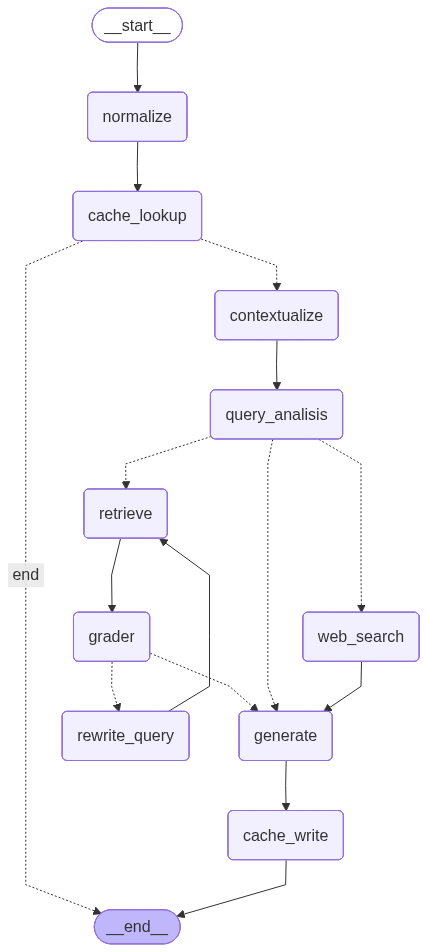

In [101]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [155]:

from langsmith import traceable, wrappers

@traceable
def target_graph(inputs: dict) -> dict:
    """
    Fungsi ini menjembatani Dataset LangSmith dengan Graph RAG kamu.
    """
    if isinstance(inputs, dict):
        question = inputs.get("question", "")
    else:
        question = inputs
    config = {"configurable": {"thread_id": "eval_bot"}}
    
    result = app.invoke(
        {"messages": [("user", question)]}, 
        config=config
    )
    final_answer = result["messages"][-1].content
    
    retrieved_contexts = result["retrieved_doc"]
    

    return result, {
        "question" : question,
        "answer": final_answer,
        "contexts": retrieved_contexts
    }

In [148]:
def correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    messages, answer, reference_outputs =  target_graph("carikan kandidat andi dan beritahu skill dia apa aja")
    
    question = inputs["normalized_question"]
    result = answer["answer"]
    
    return result == reference_outputs["label"]


In [156]:
inputs = {"question" : "analisis kandidat bernama SIti, apakah menurut kamu dia bisa menggunakan gen ai?"}
msg, answer = target_graph(inputs)

--- CONTEXTUALIZE QUERY ---
Original: analisis kandidat bernama SIti, apakah menurut kamu dia bisa menggunakan gen ai?
Contextualized: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
--- ROUTE QUERY ---
Question: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
Decision: retrieve
--- ROUTING TO: retrieve ---
Retrieving for: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
--- CHECK DOCUMENT RELEVANCE ---
--- GRADE: DOCUMENT RELEVANT ---
Nama: Andi Pratama  
Email: andi.pratama@email.dummy  
Lokasi: Jakarta Selatan, Indonesia  
LinkedIn: linkedin.com/in/andipratama-ai 
Ringkasan Profesional AI Engineer berpengalaman dengan spesialisasi dalam Natural 
Language Processing (NLP) dan Generative AI. Memiliki pengalaman 4 tahun dalam 
membangun sistem retrieval-augmented generation (RAG) berskala besar dan deploy model 
LLM ke produksi. 
Pengalaman Kerja 
• 
Senior AI Engineer - TechInovasi Indonesia (Jan 2023 - Sekarang) 
o Memimpin pengembangan chatbo

In [158]:
msg

{'messages': [HumanMessage(content='carikan kandidat yang berasal dari jakarta selatan dan dekat dari bandung', additional_kwargs={}, response_metadata={}, id='4271ba93-0e4c-40dd-a78b-3136de77a927'),
  AIMessage(content='Berikut kandidat yang **berasal dari Jakarta Selatan**:\n\n- **Nama:** Andi Pratama  \n- **Email:** andi.pratama@email.dummy  \n- **Lokasi:** Jakarta Selatan, Indonesia  \n- **LinkedIn:** linkedin.com/in/andipratama-ai  \n- **Ringkasan Profesional:** AI Engineer dengan spesialisasi NLP dan Generative AI, berpengalaman 4 tahun dalam sistem retrieval‑augmented generation (RAG) dan deployment LLM.  \n\n**Catatan:**  \nTidak ada informasi dalam data kandidat mengenai kedekatannya dengan Bandung.  \n\nJika Anda memerlukan kandidat lain atau informasi tambahan, mohon berikan detail lebih lanjut.', additional_kwargs={'reasoning_content': 'The user asks: "carikan kandidat yang berasal dari jakarta selatan dan dekat dari bandung". They want to find a candidate who is from Jakar

In [159]:
for message in msg["messages"]:
    message.pretty_print()

================================ Human Message =================================

carikan kandidat yang berasal dari jakarta selatan dan dekat dari bandung
================================== Ai Message ==================================

Berikut kandidat yang **berasal dari Jakarta Selatan**:

- **Nama:** Andi Pratama  
- **Email:** andi.pratama@email.dummy  
- **Lokasi:** Jakarta Selatan, Indonesia  
- **LinkedIn:** linkedin.com/in/andipratama-ai  
- **Ringkasan Profesional:** AI Engineer dengan spesialisasi NLP dan Generative AI, berpengalaman 4 tahun dalam sistem retrieval‑augmented generation (RAG) dan deployment LLM.  

**Catatan:**  
Tidak ada informasi dalam data kandidat mengenai kedekatannya dengan Bandung.  

Jika Anda memerlukan kandidat lain atau informasi tambahan, mohon berikan detail lebih lanjut.
================================ Human Message =================================

carikan kandidat yang berasal dari jakarta selatan dan dekat dari bandung
====================

In [160]:
answer

{'question': 'analisis kandidat bernama SIti, apakah menurut kamu dia bisa menggunakan gen ai?',
 'answer': 'Maaf, informasi tersebut tidak ditemukan dalam data kandidat.',
 'contexts': [Document(id='c5e58088-0a91-4c68-8589-6f45ea680925', metadata={'producer': 'Microsoft® Word 2021', 'creator': 'Microsoft® Word 2021', 'creationdate': '2026-02-03T06:51:56+07:00', 'source': 'Andi.pdf', 'file_path': 'Andi.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': 'Farhan Kamil', 'subject': '', 'keywords': '', 'moddate': '2026-02-03T06:51:56+07:00', 'trapped': '', 'modDate': "D:20260203065156+07'00'", 'creationDate': "D:20260203065156+07'00'", 'page': 0}, page_content='Nama: Andi Pratama  \nEmail: andi.pratama@email.dummy  \nLokasi: Jakarta Selatan, Indonesia  \nLinkedIn: linkedin.com/in/andipratama-ai \nRingkasan Profesional AI Engineer berpengalaman dengan spesialisasi dalam Natural \nLanguage Processing (NLP) dan Generative AI. Memiliki pengalaman 4 tahun dalam \nmembangun sist

In [122]:
from langsmith import Client
ls_client = Client()

examples = [
  {
    "inputs": {"text": "apakah andi sangat jago dalam gen ai?"},
    "outputs": {"label": "iya dia sangat hebat dan itu adalah bidang dia Gen Ai"},
  },
]

dataset = ls_client.create_dataset(dataset_name="Evaluation HR")
ls_client.create_examples(
  dataset_id=dataset.id,
  examples=examples,
)

{'example_ids': ['579612ab-6b60-4dfc-bcf0-7df81eb24fde'], 'count': 1}

In [161]:

results = ls_client.evaluate(
    target_graph,
    data=dataset.name,
    evaluators=[correct],
    experiment_prefix="gpt-4.1-mini, baseline",  # optional, experiment name prefix
    description="Testing the baseline system.",  # optional, experiment description
    max_concurrency=4, # optional, add concurrency
)

View the evaluation results for experiment: 'gpt-4.1-mini, baseline-41f81fc6' at:
https://smith.langchain.com/o/14ffe126-84d6-4178-b017-aa80d0e093e0/datasets/d2eaaf49-a647-4a74-8fe5-05951d65e458/compare?selectedSessions=069f6260-488e-44ab-b0a0-c7cfa68928dd




0it [00:00, ?it/s]

--- CACHE MISS ---
--- CONTEXTUALIZE QUERY ---
Original: 
Contextualized: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
--- ROUTE QUERY ---
Question: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
Decision: retrieve
--- ROUTING TO: retrieve ---
Retrieving for: Apakah kandidat bernama Siti dapat menggunakan Generative AI?
--- CHECK DOCUMENT RELEVANCE ---
--- GRADE: DOCUMENT NOT RELEVANT ---
Nama: Andi Pratama  
Email: andi.pratama@email.dummy  
Lokasi: Jakarta Selatan, Indonesia  
LinkedIn: linkedin.com/in/andipratama-ai 
Ringkasan Profesional AI Engineer berpengalaman dengan spesialisasi dalam Natural 
Language Processing (NLP) dan Generative AI. Memiliki pengalaman 4 tahun dalam 
membangun sistem retrieval-augmented generation (RAG) berskala besar dan deploy model 
LLM ke produksi. 
Pengalaman Kerja 
• 
Senior AI Engineer - TechInovasi Indonesia (Jan 2023 - Sekarang) 
o Memimpin pengembangan chatbot layanan pelanggan menggunakan Llama 3 
dan LangChain, m

Error running evaluator <DynamicRunEvaluator correct> on run 019c31f1-9d25-78e1-810e-c7f9c2a04b5b: ValueError('not enough values to unpack (expected 3, got 2)')
Traceback (most recent call last):
  File "d:\LIFE\_BOOTCAMP_MANDIRI\B11_LANGGRAPH\.venv\Lib\site-packages\langsmith\evaluation\_runner.py", line 1585, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\LIFE\_BOOTCAMP_MANDIRI\B11_LANGGRAPH\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line 353, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "d:\LIFE\_BOOTCAMP_MANDIRI\B11_LANGGRAPH\.venv\Lib\site-packages\langsmith\run_helpers.py", line 710, in wrapper
    function_result = run_container["context"].run(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\LIFE\_BOOTCAMP_MANDIRI\B11_LANGGRAPH\.venv\Lib\site-packages\langsmith\evaluation\evaluator.py", line

--- ANSWER CACHED ---
